<a href="https://colab.research.google.com/github/riyagpt0251/Bridge-stability-prediction/blob/main/Bridge_stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas scikit-learn matplotlib seaborn

#import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#load dataset

In [ ]:
df = pd.read_csv("Last_Year_All_Field_Bridges.csv")

# clean and prepare dataset

In [ ]:
df = pd.read_csv("Last_Year_All_Field_Bridges.csv")
print(df.columns.tolist())


['1 - State Code', '1 - State Name', '8 - Structure Number', '22 - Owner Agency', '3 - County Code', '3 - County Name', '4 - Place Code', 'City - InfoBridge Place Code', 'City - InfoBridge Place Name', '27 - Year Built', '29 - Average Daily Traffic', '43A - Main Span Material', '43B - Main Span Design', '45 - Number of Spans in Main Unit', '49 - Structure Length (ft.)', '6A - Features Intersected', '7 - Facility Carried By Structure', 'CAT10 - Bridge Condition', 'Bridge Age (yr)', 'CAT29 - Deck Area (sq. ft.)', '2 - Highway Agency District', '9 - Location', '11 - Mile Point (miles)', '16 - Latitude (decimal)', '17 - Longitude (decimal)', '21 - Maintenance Responsibility', '37 - Historical Significance Code', '98A - Neighboring State Name', '98B - Neighboring State Percent Responsibility', '99 - Border Bridge Structure Number', '101 - Parallel Structure Designation Code', '106 - Year Reconstructed', '44A - Approach Spans Material', '44B - Approach Spans Design', '46 - Number of Approach

<ipython-input-6-1695d4afcad5>:1: DtypeWarning: Columns (29,84,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Last_Year_All_Field_Bridges.csv")


In [ ]:
df.columns = df.columns.str.strip()

df = df[['27 - Year Built',
         '49 - Structure Length (ft.)',
         '52 - Deck Width - Out to Out (ft.)',
         '29 - Average Daily Traffic',
         '109 - Average Daily Truck Traffic (Percent ADT)']].dropna()

In [ ]:
df.columns = ['YearBuilt', 'LengthFt', 'DeckWidthFt', 'DailyTraffic', 'TruckTrafficPercent']

In [ ]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

# Compute estimated bending moment (simplified): M = wL²/8
# Assume: total weight w = daily traffic * truck factor * unit load (e.g., 0.75 tons)


In [ ]:

df['TotalLoad'] = df['DailyTraffic'] * (df['TruckTrafficPercent'] / 100) * 0.75  # simplified estimate
df['BendingMoment'] = (df['TotalLoad'] * df['LengthFt'] ** 2) / 8

# Approximate moment of resistance (assume linear with deck width)


In [ ]:
df['MomentOfResistance'] = df['DeckWidthFt'] * 10

# Estimate work life remaining


In [ ]:
df['BridgeAge'] = 2025 - df['YearBuilt']
df['EstimatedWorkLifeRemaining'] = 100 - df['BridgeAge']

# Estimate number of truss components based on span


In [ ]:
df['TrussComponents'] = (df['LengthFt'] // 10).astype(int)

# show some result

In [ ]:
print(df[['YearBuilt', 'LengthFt', 'DeckWidthFt', 'TotalLoad',
          'BendingMoment', 'MomentOfResistance',
          'EstimatedWorkLifeRemaining', ]].head())

   YearBuilt  LengthFt  DeckWidthFt  TotalLoad  BendingMoment  \
2       1990      63.0         16.1    15.9000   7.888388e+03   
3       1962     110.9         80.4   278.7000   4.284598e+05   
4       1975     120.1         27.6     3.6750   6.626030e+03   
5       1960    1433.1         34.4    61.6500   1.582691e+07   
6       2018    1294.9         30.5     2.9625   6.209274e+05   

   MomentOfResistance  EstimatedWorkLifeRemaining  
2               161.0                          65  
3               804.0                          37  
4               276.0                          50  
5               344.0                          35  
6               305.0                          93  


# plot bending moment vs deck width

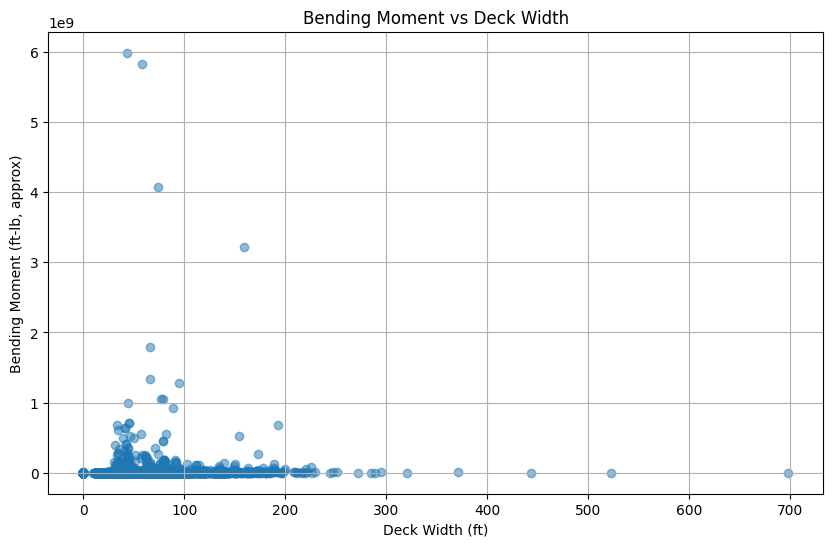

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['DeckWidthFt'], df['BendingMoment'], alpha=0.5)
plt.xlabel("Deck Width (ft)")
plt.ylabel("Bending Moment (ft-lb, approx)")
plt.title("Bending Moment vs Deck Width")
plt.grid(True)
plt.show()

# plot sfd and bmd

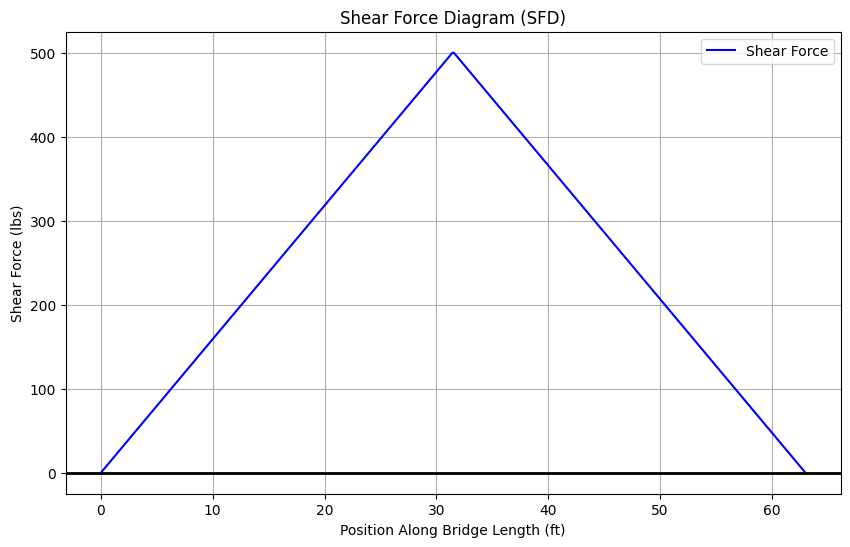

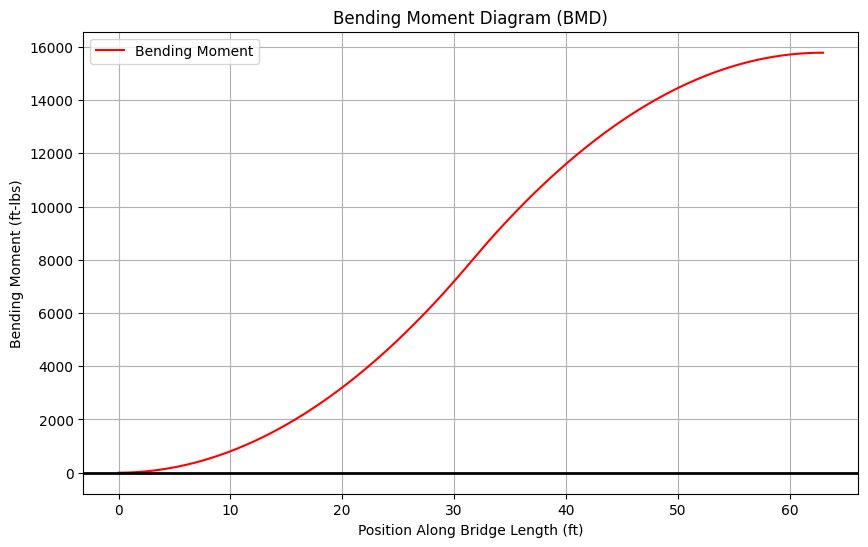

In [18]:
def plot_sfd_bmd(length, load):
    # Simplified load distribution - concentrated load at the center of the span
    x = np.linspace(0, length, 500)

    # Shear force calculation (uniform load assumption)
    shear_force = load * (length / 2 - np.abs(x - length / 2))

    # Bending moment calculation
    bending_moment = np.cumsum(shear_force) * (x[1] - x[0])  # Approximate by summing shear force * dx

    # Plot Shear Force Diagram (SFD)
    plt.figure(figsize=(10,6))
    plt.plot(x, shear_force, label="Shear Force", color='b')
    plt.axhline(0, color='k', lw=2)
    plt.title("Shear Force Diagram (SFD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Shear Force (lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Bending Moment Diagram (BMD)
    plt.figure(figsize=(10,6))
    plt.plot(x, bending_moment, label="Bending Moment", color='r')
    plt.axhline(0, color='k', lw=2)
    plt.title("Bending Moment Diagram (BMD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Bending Moment (ft-lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage with data from the first bridge in the dataset
example_length = df['LengthFt'].iloc[0]  # First bridge length
example_load = df['TotalLoad'].iloc[0]  # First bridge load

plot_sfd_bmd(example_length, example_load)

# user input basis calculation

Enter the length of the bridge (in feet): 2000
Enter the deck width of the bridge (in feet): 400
Enter the average daily traffic (number of vehicles per day): 11000
Enter the percentage of truck traffic: 12
Bending Moment (approx): 495000000.00 ft-lb
Moment of Resistance (approx): 4000.00 ft-lb
Bridge is at risk of failure due to excessive bending moment.


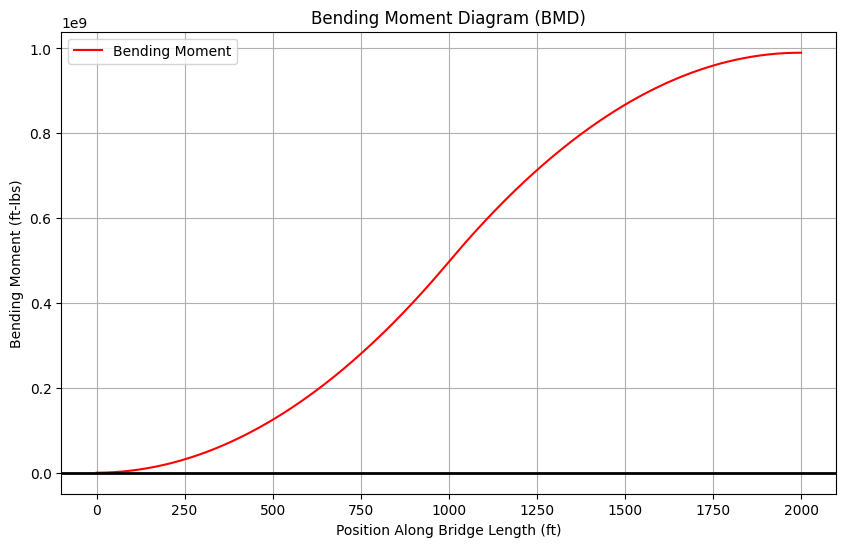

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Bending Moment
def calculate_bending_moment(length, daily_traffic, truck_traffic_percent, deck_width):
    # Assume: total weight w = daily traffic * truck factor * unit load (e.g., 0.75 tons)
    total_load = daily_traffic * (truck_traffic_percent / 100) * 0.75  # simplified estimate in tons
    bending_moment = (total_load * length ** 2) / 8  # Simple formula for bending moment (wL^2/8)

    # Moment of Resistance: Assumed linear with deck width and some material factor
    moment_of_resistance = deck_width * 10  # Simplified for demonstration

    return bending_moment, moment_of_resistance

# Function to predict bridge stability based on bending moment
def predict_stability(bending_moment, moment_of_resistance):
    if bending_moment > moment_of_resistance:
        return "Bridge is at risk of failure due to excessive bending moment."
    else:
        return "Bridge is stable under current load conditions."

# Function to take user input and predict bending moment and stability
def bridge_stability_analysis():
    # Taking user inputs for various characteristics of the bridge
    length = float(input("Enter the length of the bridge (in feet): "))
    deck_width = float(input("Enter the deck width of the bridge (in feet): "))
    daily_traffic = float(input("Enter the average daily traffic (number of vehicles per day): "))
    truck_traffic_percent = float(input("Enter the percentage of truck traffic: "))

    # Calculate bending moment and moment of resistance
    bending_moment, moment_of_resistance = calculate_bending_moment(length, daily_traffic, truck_traffic_percent, deck_width)

    # Predict stability based on bending moment
    stability_message = predict_stability(bending_moment, moment_of_resistance)

    # Output results
    print(f"Bending Moment (approx): {bending_moment:.2f} ft-lb")
    print(f"Moment of Resistance (approx): {moment_of_resistance:.2f} ft-lb")
    print(stability_message)

    # Plot the bending moment diagram
    x = np.linspace(0, length, 500)
    shear_force = (daily_traffic * (truck_traffic_percent / 100) * 0.75) * (length / 2 - np.abs(x - length / 2))
    bending_moment_curve = np.cumsum(shear_force) * (x[1] - x[0])  # Approximate by summing shear force * dx

    plt.figure(figsize=(10,6))
    plt.plot(x, bending_moment_curve, label="Bending Moment", color='r')
    plt.axhline(0, color='k', lw=2)
    plt.title("Bending Moment Diagram (BMD)")
    plt.xlabel("Position Along Bridge Length (ft)")
    plt.ylabel("Bending Moment (ft-lbs)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the bridge stability analysis
bridge_stability_analysis()
